# Plateau comparison
*Feb 25 2020*

In this notebook, we'll measure the strength of the plateau in the power spectrum, as a function of subhalo density and redshift. We'll use a Sheth-Tormen mass function for the interlopers when that's ready.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.cosmology import FlatLambdaCDM, z_at_value
from astropy import units as u

from scipy.integrate import quad, dblquad
from scipy.interpolate import interp1d, interp2d

from helpers import sigma_cr

cosmo = FlatLambdaCDM(H0=70, Om0=0.316)

In [2]:
z_low = .01 # for numerical reasons, sometimes we can't go all the way down to 0
m_low = 1e5 # in Msun
m_high = 1e8

In [22]:
def chi_to_z(chi):
    return z_at_value(cosmo.comoving_distance, chi*u.kpc, zmax=3.1)
def z_to_chi(z):
    return cosmo.comoving_distance(z).to(u.kpc).value
chilist = np.linspace(z_to_chi(z_low),z_to_chi(3),100)
zlist = [chi_to_z(chi) for chi in chilist]
chi_to_z_fast = interp1d(chilist, zlist)
z_to_chi_fast = interp1d(zlist, chilist)

## Subhalos
$$P(k = 0) = \frac{1}{\Sigma_{cr}^2}\int_{10^5}^{10^8} dm \, m^2 \frac{d^2N}{dmdA}(z_l,m)$$
where
$$\frac{d^2 N}{dmdA}(z_l, m) = \frac{\Sigma_{sub}^{new}}{m_0}\left(\frac{m}{m_0}\right)^{-1.9}\sqrt{1+z_l}$$
and $\Sigma_{sub}^{new} = \Sigma_{sub}^{old}/\sqrt{1+z_{old}}$.

In [3]:
m0 = 1e8 #* u.Msun
sigma_old_ana = 0.120 #/ u.kpc**2
sigma_new_ana = sigma_old_ana / np.sqrt(1+0.5) # since their main lens had $z=0.5$

Want $\Sigma_{sub}^{old} 1/m_0 \cdot m_0^{1.9} = 1.9e6 M_\odot^{0.9} \mathrm{kpc}^{-2}$

In [4]:
1.9e6 * m0 / m0**1.9

0.11988189545123691

In [5]:
sigma_cr(.5,1)

<Quantity 3.11654993e+15 solMass / Mpc2>

In [6]:
def power_sub(z_l, z_s, mlow=m_low, mhigh=m_high):
    sigcr = sigma_cr(z_l, z_s).to(u.M_sun/u.kpc**2).value
    #sigcr = 1
    def massfunc(m):
        return sigma_new_ana / m0 * (m/m0)**-1.9 * np.sqrt(1+z_l) # this integral could actually be done analytically if we want speedup
    
    #print('massfunc', massfunc(1e7))
    integral = quad(lambda m: m**2 * massfunc(m), mlow, mhigh)[0]
    #print('integral error', integral[1]/integral[0])
    return 1/sigcr**2 * integral
    
power_sub(.5,1) # This matches Ana's normalization

0.00011225938665592646

In [7]:
%%time
# Calculate subhalo power (plateau) grid
zllist = np.linspace(z_low,3,100)
zslist = np.linspace(z_low,3,100)
sub_power_grid = np.zeros((len(zllist), len(zslist)))
for i_l, z_l in enumerate(zllist):
    for i_s, z_s in enumerate(zslist):
        if z_s <= z_l: continue
        
        sub_power_grid[i_l, i_s] = power_sub(z_l, z_s)

CPU times: user 16.4 s, sys: 0 ns, total: 16.4 s
Wall time: 16.4 s


Text(0.5, 1.0, 'Subhalo plateau')

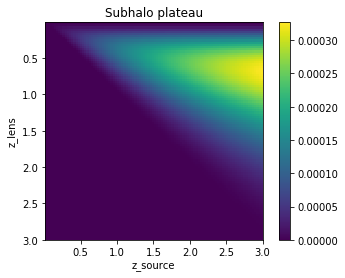

In [8]:
plt.imshow(sub_power_grid, extent=[z_low,3,3,z_low])
plt.xlabel('z_source')
plt.ylabel('z_lens')
plt.colorbar()
plt.title('Subhalo plateau')
#plt.savefig('imgs/feb25_subplat.png')

## Interlopers
To keep the integral simple, we will first start **without the effective mass ratio**.
$$P_0  \approx \frac{1}{\Sigma_{cr}^2} \int_0^{z_s} dz \frac{d\chi}{dz} \frac{R^2(z)}{R^2(z_l)} \int_{10^5}^{10^8} m^2 n(z, m) dm$$
or putting the integral directly in terms of the comoving distance,
$$P_0  \approx \frac{1}{\Sigma_{cr}^2} \int_0^{\chi_s} d\chi \frac{R^2(\chi)}{R^2(\chi_l)} \int_{10^5}^{10^8} m^2 n(z(\chi), m) dm$$

### Sheth-Tormen mass function

In [9]:
# Load ST results
h = .675
massesn = np.load('files/st_results/WIDE_massesn_ST.npy')
massfunc_mat = np.load('files/st_results/WIDE_massfunc_ST.npy') * h**3/1000**3
redshifts = np.load('files/st_results/WIDE_redshifts_ST.npy')

massfunc = interp2d(redshifts, massesn, massfunc_mat, bounds_error=True) # function of (z, mass)

In [39]:
min(massesn), '%g'%max(massesn)

(105.69345535579883, '9.46132e+13')

### Double-cone radius

In [10]:
def double_cone_direct(com_z, com_l, com_s):
    # Input can be in any units
    if com_z < com_l:
        return com_z / com_l
    else:
        return (com_s - com_z) / (com_s - com_l)

## Mass integral

First we calculate the inner integral as a function of $\chi$:
$$\int_{10^5}^{10^8} m^2 n(z(\chi), m) dm$$

In [41]:
m_low = 1e4

In [42]:
%%time
# just compute this once for all z_l and z_s
def mass_integrand(mass, chi):
    #print('z', chi_to_z(chi))
    return mass**2 * massfunc(chi_to_z_fast(chi), mass)

chi_list = np.linspace(z_to_chi(z_low),z_to_chi(3-z_low),20)
mass_integral_list = [quad(mass_integrand, m_low, m_high, args=(chi,), epsrel=1e-2)[0] for chi in chi_list]
mass_integral_func = interp1d(chi_list, mass_integral_list)

CPU times: user 132 ms, sys: 28 ms, total: 160 ms
Wall time: 143 ms


Text(0, 0.5, 'integral m^2 n dm')

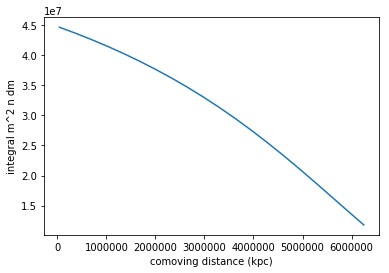

In [43]:
plt.plot(chi_list, mass_integral_list)
plt.xlabel('comoving distance (kpc)')
plt.ylabel('integral m^2 n dm')

In [44]:
def integrand(chi, chil, chis):
    # kpc_comoving
    rad_term = double_cone_direct(chi, chil, chis)**2 / 1 # denom is automatically one in our convention
    return rad_term * mass_integral_func(chi)

def interloper_power(z_l, z_s):
    assert(z_l < z_s)
    sigcr = sigma_cr(z_l, z_s).to(u.Msun/u.kpc**2).value
    res = quad(integrand, z_to_chi(z_low), z_to_chi(z_s), args=(z_to_chi(z_l), z_to_chi(z_s)))
    power = res[0]/sigcr**2
    return power # in kpc^2

In [45]:
interloper_power(.5, 1)

/home/arthur/Documents/cosmo/interlopers/venv/lib/python3.5/site-packages/ipykernel_launcher.py:9: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  if __name__ == '__main__':


4.331917892229022e-06

In [23]:
%%time

# Calculate interloper power (plateau) grid
zllist = np.linspace(z_low,3-z_low,20)
zslist = np.linspace(z_low,3-z_low,20)
int_power_grid = np.zeros((len(zllist), len(zslist)))
for i_l, z_l in enumerate(zllist):
    for i_s, z_s in enumerate(zslist):
        if z_s <= z_l: continue
        
        int_power_grid[i_l, i_s] = interloper_power(z_l, z_s)

/home/arthur/Documents/cosmo/interlopers/venv/lib/python3.5/site-packages/ipykernel_launcher.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  if __name__ == '__main__':
/home/arthur/Documents/cosmo/interlopers/venv/lib/python3.5/site-packages/ipykernel_launcher.py:9: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  if __name__ == '__main__':


CPU times: user 10.4 s, sys: 112 ms, total: 10.6 s
Wall time: 10.4 s


Text(0.5, 1.0, 'Interloper plateau')

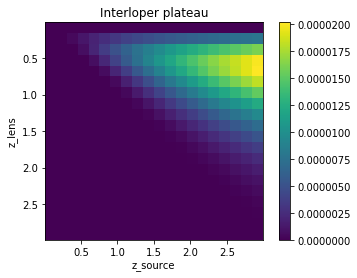

In [24]:
plt.imshow(int_power_grid, extent=[z_low,3-z_low,3-z_low,z_low])
plt.xlabel('z_source')
plt.ylabel('z_lens')
plt.colorbar()
plt.title('Interloper plateau')
#plt.savefig('imgs/feb25_intplat.png')

## First interloper / subhalo ratio plot

In [25]:
plt.imshow(int_power_grid / sub_power_grid, extent=[z_low,3-z_low,3-z_low,z_low])
plt.xlabel('z_source')
plt.ylabel('z_lens')
plt.colorbar()
plt.title('Interloper / Subhalo ratio')
#plt.savefig('imgs/feb_25_int_sub_ratio.png')

ValueError: operands could not be broadcast together with shapes (20,20) (100,100) 

## Putting $\Sigma_{cr}$ inside the integral

In [46]:
# helper functions:
def ADD(z1, z2):
    return cosmo.angular_diameter_distance_z1z2(z1,z2)
def sigma_cr_fast(zd,zs):
    const = 1.663e18*u.M_sun / u.Mpc##c^2/(4 pi G)
    return const*(ADD(0,zs)/(ADD(zd,zs)*ADD(0,zd))) ##in units Msun/Mpc^2

## real deal integral ##
def integrand2(chi, chil, chis):
    # kpc_comoving
    rad_term = double_cone_direct(chi, chil, chis)**2  # denom is automatically one in our convention
    
    sigcr = sigma_cr_fast(chi_to_z_fast(chi), chi_to_z_fast(chis)).to(u.Msun/u.kpc**2).value
    
    #sigcr *= 1e-6
    
    return rad_term * mass_integral_func(chi) / sigcr**2

def interloper_power2(z_l, z_s):
    assert(z_l < z_s)
    
    res = quad(integrand2, z_to_chi(z_low), z_to_chi(z_s), args=(z_to_chi(z_l), z_to_chi(z_s)))
    power = res[0]
    return power # in kpc^2

In [47]:
interloper_power2(.5,1)

4.040955007264579e-06

In [27]:
%%time

# Calculate interloper power (plateau) grid
zllist = np.linspace(z_low,3-z_low,20)
zslist = np.linspace(z_low,3-z_low,20)
int_power_grid2 = np.zeros((len(zllist), len(zslist)))
for i_l, z_l in enumerate(zllist):
    for i_s, z_s in enumerate(zslist):
        if z_s <= z_l: continue
        
        int_power_grid2[i_l, i_s] = interloper_power2(z_l, z_s)

CPU times: user 22.8 s, sys: 24 ms, total: 22.9 s
Wall time: 22.6 s


Text(0.5, 1.0, 'Interloper plateau ($\\Sigma_{cr}$ inside integral)')

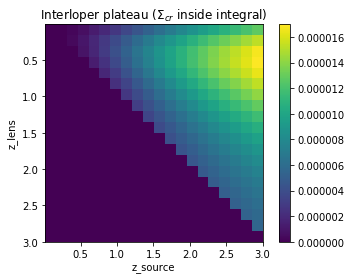

In [28]:
plt.imshow(int_power_grid2, extent=[z_low,3,3,z_low])
plt.xlabel('z_source')
plt.ylabel('z_lens')
plt.colorbar()
plt.title('Interloper plateau ($\\Sigma_{cr}$ inside integral)')
#plt.savefig('imgs/feb25_int2plat.png')

/home/arthur/Documents/cosmo/interlopers/venv/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Log10 ratio of plateau: $\\Sigma_{cr}$ inside / $\\Sigma_{cr}$ outside')

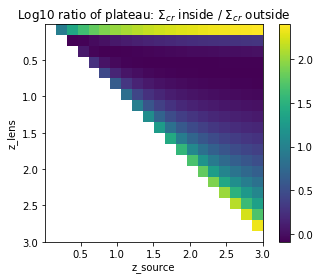

In [29]:
plt.imshow(np.log10(int_power_grid2 / int_power_grid), extent=[z_low,3,3,z_low])
plt.xlabel('z_source')
plt.ylabel('z_lens')
plt.colorbar()
plt.title(r'Log10 ratio of plateau: $\Sigma_{cr}$ inside / $\Sigma_{cr}$ outside')
#plt.savefig('imgs/feb26_in_out_ratio.png')

## Effective mass ratio

In [40]:
def meff_ratio(z_inter, z_lens, z_source):
    # z_inter is the redshift of the interloper
    #a_inter = 1/(1+z_inter)
    #a_source = 1/(1+z_source)
    #chi_inter = cosmo.comoving_distance(z_inter)
    #chi_source = cosmo.comoving_distance(z_source)
    D_i = cosmo.angular_diameter_distance(z_inter) # a_inter * chi_inter
    D_l = cosmo.angular_diameter_distance(z_lens)
    D_s = cosmo.angular_diameter_distance(z_source)
    D_is = cosmo.angular_diameter_distance_z1z2(z_inter, z_source) # a_source * (chi_source - chi_inter)
    D_ls = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)
    
    if z_inter == z_lens:
        return 1
    elif z_inter < z_lens: # foreground interloper
        return D_i * D_is / D_l / D_ls
    else: # background interloper
        #chi_lens = cosmo.comoving_distance(z_lens)
        #D_li = a_inter * (chi_inter - chi_lens)
        D_li = cosmo.angular_diameter_distance_z1z2(z_lens, z_inter)
        return (1-D_li*D_s/D_i/D_ls)*D_i*D_is/D_l/D_ls

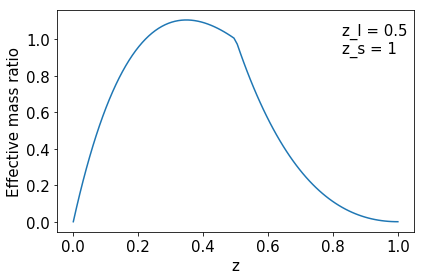

In [41]:
z_l_temp = .5
z_s_temp = 1

fig = plt.figure()
z_vals = np.linspace(0,z_s_temp,100)
meff_vals = np.array([meff_ratio(z, z_l_temp, z_s_temp) for z in z_vals])
plt.plot(z_vals, meff_vals)
plt.xlabel('z',fontsize=15)
plt.ylabel('Effective mass ratio',fontsize=15)
plt.gca().tick_params(labelsize=15)
fig.text(.8,.8,'z_l = {}\nz_s = {}'.format(z_l_temp, z_s_temp),size=15)
plt.tight_layout()
#plt.savefig('imgs/feb29_meffratio3.pdf')
plt.show()

Again, we first do the mass integrand, where the bounds are controlled by $m_\mathrm{eff}$:
$$\int_{10^5}^{10^8} dm_\mathrm{eff} \frac{1}{f} n\left(z, \frac{m_\mathrm{eff}}{f}\right) m_\mathrm{eff}^2$$
where $f$ is the mass ratio graphed above.

In [43]:
def mass_integral(z, z_lens, z_source):
    f = meff_ratio(z, z_lens, z_source)
    f = max(f, .1) # to keep things within bounds (BUT THIS IS AN OVERESTIMATE)
    #if f < .1: return 0
    def mass_integrand(meff):
        return 1/f * massfunc(z, meff/f) * meff**2
    
    return quad(mass_integrand, m_low, m_high, epsrel=.01)[0]

And then we do the full integral:
$$\frac{1}{\Sigma_{cr}^2}\int_0^{\chi(3)} d\chi \frac{R^2(z)}{R^2_l(z)} [\mathrm{Mass\, integral}]$$

In [51]:
def interloper_power_meff(z_lens, z_source):
    sigcr = sigma_cr(z_lens, z_source).to(u.Msun/u.kpc**2).value
    chi_lens = z_to_chi(z_lens)
    chi_source = z_to_chi(z_source)
    res = quad(lambda chi: double_cone_direct(chi, chi_lens, chi_source)**2 
               * mass_integral(chi_to_z_fast(chi), z_lens, z_source),
               z_to_chi(z_low), z_to_chi(z_source),
              epsrel=.01)
    #print('res', res)
    #print('sigcr', sigcr)
    
    return res[0] / sigcr**2

In [52]:
#total
interloper_power_meff(.5,1)

3.7359494812041463e-06

In [47]:
# foreground
interloper_power_meff(.5, 1)

2.675188033392571e-06

In [49]:
# background
interloper_power_meff(.5, 1)

1.0608524729995961e-06

In [38]:
%%time

# Calculate interloper power (plateau) grid
zllist = np.linspace(z_low,3,20)
zslist = np.linspace(z_low,3,20)
int_power_grid3 = np.zeros((len(zllist), len(zslist)))
for i_l, z_l in enumerate(zllist):
    for i_s, z_s in enumerate(zslist):
        if z_s <= z_l: continue
        
        int_power_grid3[i_l, i_s] = interloper_power_meff(z_l, z_s)

CPU times: user 10min 51s, sys: 3.34 s, total: 10min 54s
Wall time: 10min 44s


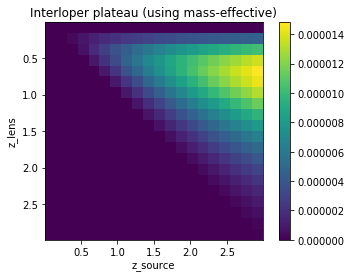

In [75]:
plt.imshow(int_power_grid3, extent=[z_low,3-z_low,3-z_low,z_low])
plt.xlabel('z_source')
plt.ylabel('z_lens')
plt.colorbar()
plt.title('Interloper plateau (using mass-effective)')
#plt.savefig('imgs/feb29_meffgrid.png')

/home/arthur/Documents/cosmo/interlopers/venv/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


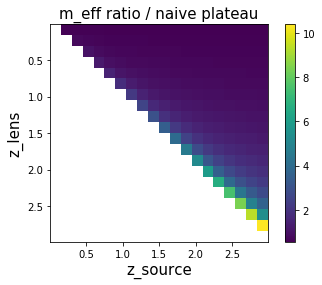

In [66]:
plt.imshow(int_power_grid3/int_power_grid, extent=[z_low,3-z_low,3-z_low,z_low])
plt.xlabel('z_source', size=15)
plt.ylabel('z_lens', size=15)
plt.colorbar()
plt.title('m_eff ratio / naive plateau', size=15)
plt.savefig('imgs/feb29_meffnomeff.png')

## New effective mass ratio

In [16]:
from helpers import ADD
def meff_ratio_new(zi,zl,zs):
    Dl = ADD(0.,zl)
    Di = ADD(0.,zi)
    Ds = ADD(0.,zs)
    Dls = ADD(zl,zs)
    Dis = ADD(zi,zs)
    if zi < zl:
        Dil = ADD(zi,zl)
        return (((Dl/Di))*(Dis/Dls))*(1.+((Dil*Ds)/(Dis*Dl)))
    if zi >= zl:
        Dli = ADD(zl,zi)
        return ((Dl/Di))*(Dis/Dls)*(1./(1.-((Dli*Ds)/(Dls*Di))))

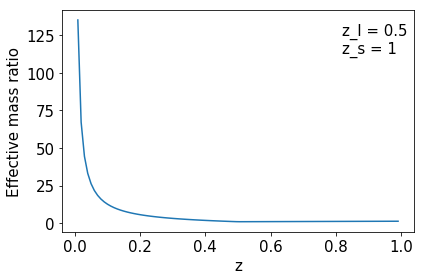

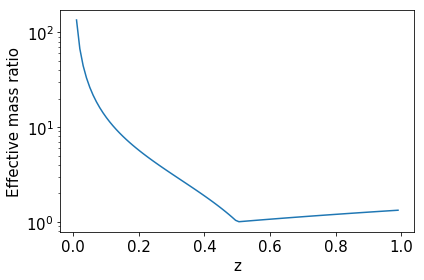

In [31]:
z_l_temp = .5
z_s_temp = 1

fig = plt.figure()
z_vals = np.linspace(0,z_s_temp,100)
meff_vals = np.array([meff_ratio_new(z, z_l_temp, z_s_temp) for z in z_vals])
plt.plot(z_vals, meff_vals)
plt.xlabel('z',fontsize=15)
plt.ylabel('Effective mass ratio',fontsize=15)
plt.gca().tick_params(labelsize=15)
fig.text(.8,.8,'z_l = {}\nz_s = {}'.format(z_l_temp, z_s_temp),size=15)
plt.tight_layout()
plt.show()

plt.plot(z_vals, meff_vals)
plt.gca().set_yscale('log')
plt.xlabel('z',fontsize=15)
plt.ylabel('Effective mass ratio',fontsize=15)
plt.gca().tick_params(labelsize=15)
fig.text(.8,.8,'z_l = {}\nz_s = {}'.format(z_l_temp, z_s_temp),size=15)
plt.tight_layout()
plt.show()

In [35]:
def mass_integral_new(z, z_lens, z_source):
    f = meff_ratio_new(z, z_lens, z_source)
    f = max(f, .1) # to keep things within bounds (BUT THIS IS AN OVERESTIMATE)
    #if f < .1: return 0
    def mass_integrand(meff):
        return 1/f * massfunc(z, meff/f) * meff**2
    
    return quad(mass_integrand, m_low, m_high, epsrel=.01)[0]

In [36]:
def interloper_power_meff_new(z_lens, z_source):
    sigcr = sigma_cr(z_lens, z_source).to(u.Msun/u.kpc**2).value
    chi_lens = z_to_chi(z_lens)
    chi_source = z_to_chi(z_source)
    res = quad(lambda chi: double_cone_direct(chi, chi_lens, chi_source)**2 
               * mass_integral_new(chi_to_z_fast(chi), z_lens, z_source),
               z_to_chi(z_low), z_to_chi(z_source),
              epsrel=.01)
    #print('res', res)
    #print('sigcr', sigcr)
    
    return res[0] / sigcr**2

In [37]:
%%time
interloper_power_meff_new(.5, 1)

CPU times: user 1.91 s, sys: 16 ms, total: 1.92 s
Wall time: 1.89 s


8.601362820031927e-06

## Old cells